In [ ]:
!qbraid jobs enable amazon_braket

In [4]:
import numpy as np
import json
import matplotlib.pyplot as plt
from pprint import pprint as pp
import networkx as nx

from braket.aws import AwsDevice
from braket.aws.aws_quantum_task import AwsQuantumTask
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.devices import LocalSimulator


from quera_ahs_utils.plotting import show_global_drive, show_register
from quera_ahs_utils.drive import get_drive 

from iquhack_utils import find_UDG_radius, visualize_graph, get_blockade_radius, get_graph_from_blockade_radius, C6, save_result_json, open_json

from utils import postprocess_MIS, analysis_MIS

In [9]:
plt.rcParams['figure.dpi'] = 140

In [10]:
qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")
capabilities = qpu.properties.paradigm
pp(capabilities.dict())

C6 = float(capabilities.rydberg.dict()['c6Coefficient']) # rad m^6/sec

{'braketSchemaHeader': {'name': 'braket.device_schema.quera.quera_ahs_paradigm_properties',
                        'version': '1'},
 'lattice': {'area': {'height': Decimal('0.000076'),
                      'width': Decimal('0.000075')},
             'geometry': {'numberSitesMax': 256,
                          'positionResolution': Decimal('1E-7'),
                          'spacingRadialMin': Decimal('0.000004'),
                          'spacingVerticalMin': Decimal('0.000004')}},
 'performance': {'lattice': {'positionErrorAbs': Decimal('1E-7')},
                 'rydberg': {'rydbergGlobal': {'rabiFrequencyErrorRel': Decimal('0.02')}}},
 'qubitCount': 256,
 'rydberg': {'c6Coefficient': Decimal('5.42E-24'),
             'rydbergGlobal': {'detuningRange': (Decimal('-125000000.0'),
                                                 Decimal('125000000.0')),
                               'detuningResolution': Decimal('0.2'),
                               'detuningSlewRateMax': Decimal(

# Points: 99


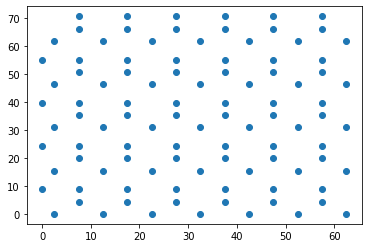

In [11]:
points = np.load("quackbone v4.npy")
# points = np.delete(points, 40, axis=0)

# print(f"Points: {points}")
print(f"# Points: {len(points)}")
plt.scatter(*zip(*(points)))
plt.show()

Blockade Radius: 7.328e-06m


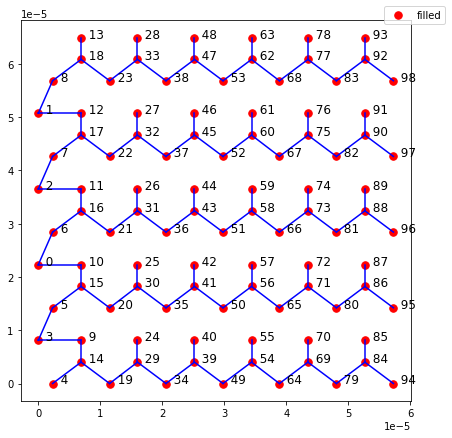

In [12]:
# detuning_final = 20e6 # rad/sec
detuning_final = 35e6 # rad/sec
# unitdisk_radius = np.sqrt(np.sqrt(2)) # 1 —> sqrt2
# Find blockade radius
blockade_radius = get_blockade_radius(detuning_final, 0) # no rabi amplitude at the end
print('Blockade Radius: {:0.3e}m'.format(blockade_radius))
# print('Unit Disk Radius: {:0.3f}'.format(unitdisk_radius))

# Compute scaling value a, which converts between logical and physical coordinates
# Quackbone is already properly scaled!
a = blockade_radius/8
# Generate the atom register
register = AtomArrangement()
for x in points:
    register.add((a * np.array(x)).round(7))

# print(register)
show_register(register, blockade_radius = blockade_radius)

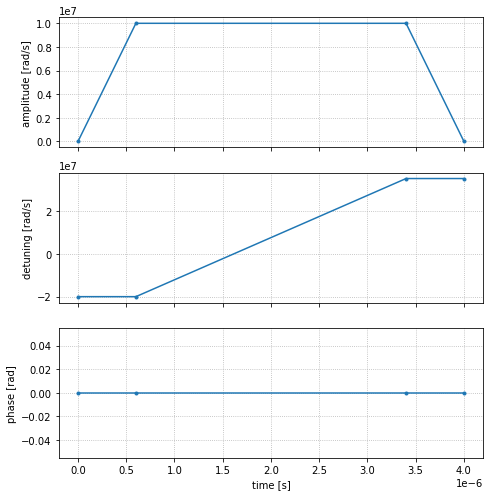

In [13]:
# Define a set of time points
time_points = [0, 0.6e-6, 3.4e-6, 4e-6]

# Define the strength of the transverse field Ω
amplitude_min = 0
amplitude_max = 10e6  # rad / sec

# Define the strength of the detuning Δ
detuning_initial = -20e6     # rad / sec
detuning_final = detuning_final # Defined above

amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]  # piecewise linear
detuning_values = [detuning_initial, detuning_initial, detuning_final, detuning_final]  # piecewise linear
phase_values = [0, 0, 0, 0]  # piecewise constant

# Define the drive
drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)
show_global_drive(drive);

In [14]:
ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=drive
)

In [ ]:
raise BaseException("Only run this cell when you are ready to submit your job.")
if points.size > 12:
    raise BaseException(f"Are you sure you want to simulate a {len(points)}-vert graph?")
device = LocalSimulator("braket_ahs")
ahs_run = device.run(ahs_program, shots=1)

result  = ahs_run.result()
save_result_json("square_lattice_mis.json", result)

In [15]:
raise BaseException("Only run this cell when you are ready to submit your job.")
# DO NOT RUN THIS UNLESS YOU ARE SURE
nshots = 100
task = qpu.run(ahs_program, shots=nshots)
print(task)

BaseException: Only run this cell when you are ready to submit your job.

In [7]:
result  = task.result()
save_result_json("quackbone v4_mis.json", result)

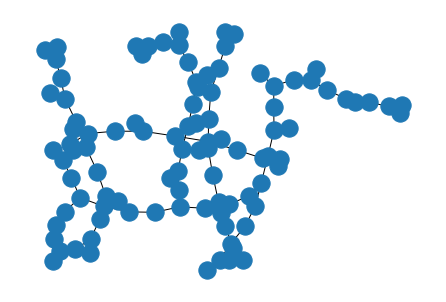

In [16]:
graph, _ = get_graph_from_blockade_radius(register, blockade_radius)
nx.draw(graph)

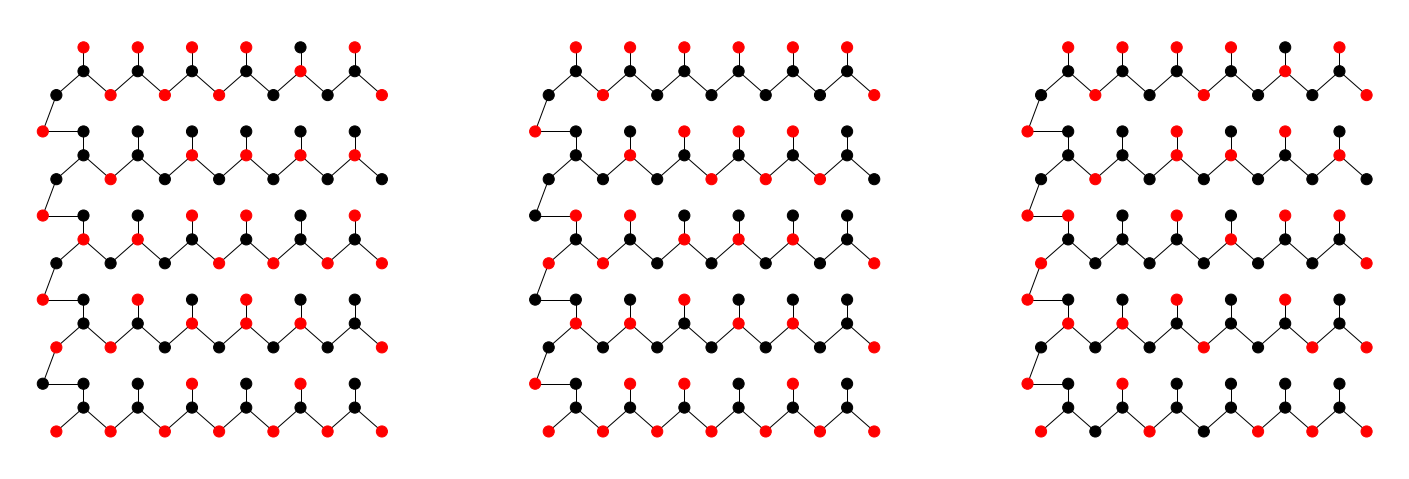

In [17]:
filename = "quackbone v4_mis.json"
result_json = open_json(filename)
num_measurements = len(result_json["measurements"])
sequences = [result_json["measurements"][i]["post_sequence"] for i in [0,num_measurements-2,num_measurements-1]]

fig = plt.figure(figsize=(25,15))
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    
    color_lookup = {0:"r",1:'k'}
    seqs_color = [color_lookup[sequences[i][j]] for j in range(len(sequences[i]))]
    visualize_graph(ax, graph, points, node_colors = seqs_color)
plt.show()

Average pre-processed size:  39.0900
Average post-processed IS size: 38.2593


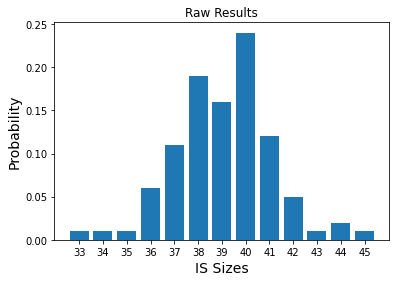

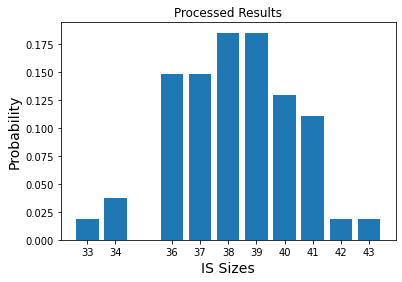

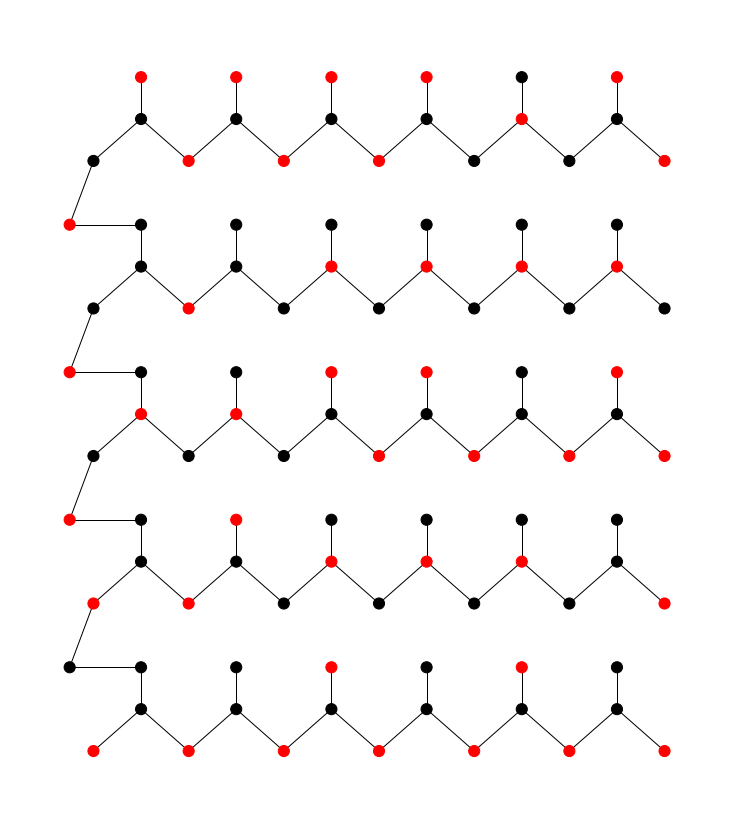

In [18]:
# filename = "lieb_lattice_4x5_mis.json"
result_json = open_json(filename)
IS_sizes,pp_bitstrings = analysis_MIS(graph, result_json)

ind, = np.where(IS_sizes==IS_sizes.max())
n_show = min(len(ind),1)

figure = plt.figure(figsize=(25,15))
for i in range(n_show):
    axes = plt.subplot(1,n_show,i+1)

    color_lookup = {0:"r",1:'k'}
    seqs_color = [color_lookup[pp_bitstrings[ind[i]][j]] for j in range(len(pp_bitstrings[ind[i]]))]
    visualize_graph(axes, graph, {a: points[a] for a in range(len(points))}, node_colors = seqs_color)
    
    # print(np.where(pp_bitstrings[ind[i]]==0)[0])
    # print(seqs_color)
    
plt.show()